# Natural Language Processing

In this notebook I will develop a NLP model to analyze IMDB dataset. I will use the raw dataset, so it is needed to make word embedding.

The individual training reviews will be collected into a list of strings, one string per review. Thre review labels will be also collected in a list

In [1]:
import os

imdb_dir = './aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding="utf8")
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

I will use a pretrained word embedding, so I restrict the training data to the first 200 samples.

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Cuts off reviews after 100 words
max_len = 100
# Trains on 200 samples
training_samples = 200
# Validates on 10,000
validation_samples = 10000
# Considers only the top 10,000 words in the dataset
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print(f'The total of unique tokens are {len(word_index)}')

data = pad_sequences(sequences, maxlen=max_len)

labels = np.asarray(labels)
print(f'Shape of tensor data: {data.shape}')
print(f'Shape of label tensor: {labels.shape}')

# Split the data into a training set and a
# validation set, but first shuffles the data,
# because u r starting with data in wich
# samples are ordered (all negativ first, then
# all positive)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

The total of unique tokens are 88582
Shape of tensor data: (25000, 100)
Shape of label tensor: (25000,)


I download the Glove word embeddings from *[Stanford web page](http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip)*. The unzipped file need to be parsed to build an index that maps words to their vector representation

In [ ]:
glove_dir = './glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    
f.close()
print(f'{len(embeddings_index)} words vectors were found.')

Next I build embeddin matrix that can be loaded into a $Embeding$ layer. It must be a matrix must be a matrix of shape $(max_words, embedding_dim)$ where each entry $i$ contains the $embedding_dim$-dimensional vector for the word of index $i$ in the reference word intex (built during tokenization). Note that index 0 isn't supposed to stand for any word or toker, it's a placeholder.

In [14]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    # Avoid out of bounds IndexError
    if i >= max_words:
        break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

Now I build the model

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


### Loading the GloVe embeddings in the model

The Embedding layer has a single weight matrix: a 2D float matrix where each entry i is the word vector meant to be associated with index i. The GloVe matrix will  be laoded in the firs layer of the model.

In [18]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False 

Setting the layer trainable attribute to False the Embedding layer will be freeze. The large gradient updates during trainning, to avoid the randomly initialized layers would be disruptive to the already-learning features.

### Training and Evaluating the Model

In [20]:
model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['acc']
)
history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(x_val, y_val)
)
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 1s 148ms/step - loss: 0.3513 - acc: 0.7575 - val_loss: 0.7950 - val_acc: 0.5741
Epoch 2/10
7/7 [==============================] - 1s 126ms/step - loss: 0.0168 - acc: 1.0000 - val_loss: 0.8194 - val_acc: 0.5734
Epoch 3/10
7/7 [==============================] - 1s 124ms/step - loss: 0.0135 - acc: 1.0000 - val_loss: 0.8260 - val_acc: 0.5761
Epoch 4/10
7/7 [==============================] - 1s 124ms/step - loss: 0.0099 - acc: 1.0000 - val_loss: 0.9207 - val_acc: 0.5659
Epoch 5/10
7/7 [==============================] - 1s 125ms/step - loss: 0.0073 - acc: 1.0000 - val_loss: 0.8729 - val_acc: 0.5748
Epoch 6/10
7/7 [==============================] - 1s 122ms/step - loss: 0.0053 - acc: 1.0000 - val_loss: 0.8741 - val_acc: 0.5753
Epoch 7/10
7/7 [==============================] - 1s 130ms/step - loss: 0.0041 - acc: 1.0000 - val_loss: 0.8882 - val_acc: 0.5754
Epoch 8/10
7/7 [==============================] - 1s 126ms/step - loss: 0.0029 - acc: 1.00

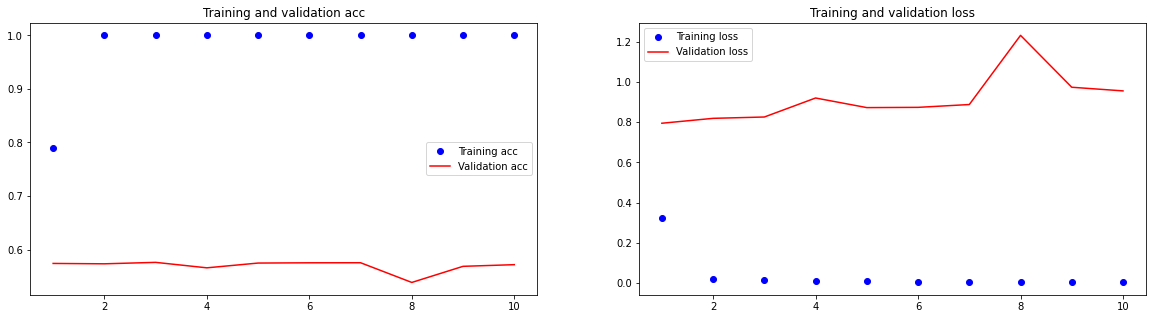

In [27]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, axs = plt.subplots(1, 2, figsize=(20,5))

axs[0].plot(epochs, acc, 'bo', label='Training acc')
axs[0].plot(epochs, val_acc, 'r', label='Validation acc')
axs[0].set_title('Training and validation acc')
axs[0].legend()

axs[1].plot(epochs, loss, 'bo', label='Training loss')
axs[1].plot(epochs, val_loss, 'r', label='Validation loss')
axs[1].set_title('Training and validation loss')
axs[1].legend()

plt.show()

The model quickly starts overfitting, which is unsurprising given the small number of training samples. Validation accuracy has high variance for the same reason, but it seems to reach the high 50s. 

Now I will train the same model wiothout loading the pretained word embeddings and without freezing the embedding layer. in that case, the model learn a task-specific embedding of the input token, which is ghenerally more powerfull than pretrained word embedding.

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['acc']
)
history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(x_val, y_val)
)
model.save_weights('model.h5')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
7/7 [==============================] - 1s 158ms/step - loss: 0.6932 - acc: 0.5197 - val_loss: 0.6913 - val_acc: 0.5256
Epoch 2/10
7/7 [==============================] - 1s 131ms/step - loss: 0.5004 - acc: 0.9767 - val_loss: 0.6947 

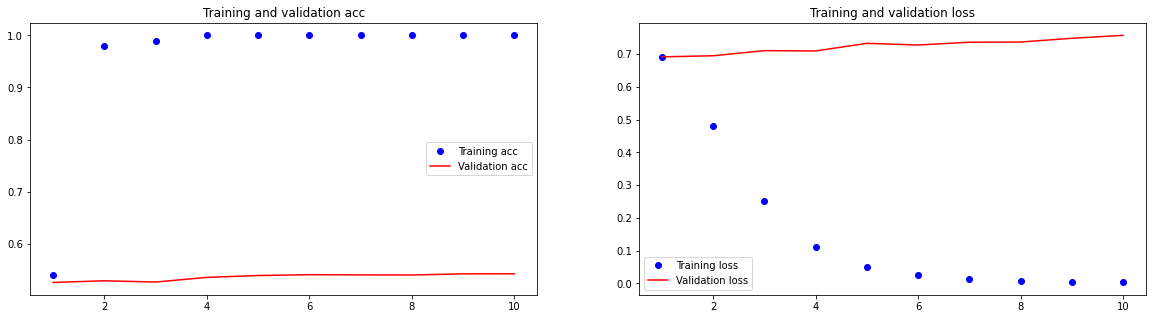

In [29]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, axs = plt.subplots(1, 2, figsize=(20,5))

axs[0].plot(epochs, acc, 'bo', label='Training acc')
axs[0].plot(epochs, val_acc, 'r', label='Validation acc')
axs[0].set_title('Training and validation acc')
axs[0].legend()

axs[1].plot(epochs, loss, 'bo', label='Training loss')
axs[1].plot(epochs, val_loss, 'r', label='Validation loss')
axs[1].set_title('Training and validation loss')
axs[1].legend()

plt.show()

Validation accuracy stalls in the low 50s. So in this case, pretrained word embeddings outperform jointly learned embeddings. If the number of training samples increase, this will quickly stop being the case.

Finaly, let's evaluate the model on the test data. Fits, the test data is tokenize.

In [ ]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding="utf8")
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
                           
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=max_len)
y_test = np.asarray(labels)

model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

## Recurrent Neuronal Network

A recurrent neural network (RNN) processes sequences by iterating through the sequence elements and manintaining a state containing information relative to what it has seen so far.

Now I will buil a RNN with Keras and compare the results, on IMDB dataset, with other solutions.

In [2]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

# Number of words to consider as features
max_features = 10000
# Cuts off texts after this many words (among the max_features most common words)
maxlen = 500
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...


<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\ala_j\.conda\envs\deep_learning\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
C:\Users\ala_j\.conda\envs\deep_learning\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sha

25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


I will build a simple recurrent network using Embedding layer and SimpleRNN layer.

In [4]:
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 128s 799ms/step - loss: 0.6745 - acc: 0.5605 - val_loss: 0.5173 - val_acc: 0.7626
Epoch 2/10
157/157 [==============================] - 126s 803ms/step - loss: 0.4099 - acc: 0.8280 - val_loss: 0.3678 - val_acc: 0.8460
Epoch 3/10
157/157 [==============================] - 125s 798ms/step - loss: 0.3056 - acc: 0.8767 - val_loss: 0.4057 - val_acc: 0.8182
Epoch 4/10
157/157 [==============================] - 126s 800ms/step - loss: 0.2363 - acc: 0.9093 - val_loss: 0.3335 - val_acc: 0.8640
Epoch 5/10
157/157 [==============================] - 125s 795ms/step - loss: 0.1760 - acc: 0.9332 - val_loss: 0.4694 - val_acc: 0.7864
Epoch 6/10
157/157 [==============================] - 130s 830ms/step - loss: 0.1276 - acc: 0.9590 - val_loss: 0.3907 - val_acc: 0.8644
Epoch 7/10
157/157 [==============================] - 126s 805ms/step - loss: 0.0841 - acc: 0.9745 - val_loss: 0.5173 - val_acc: 0.8308
Epoch 8/10
157/157 [============================

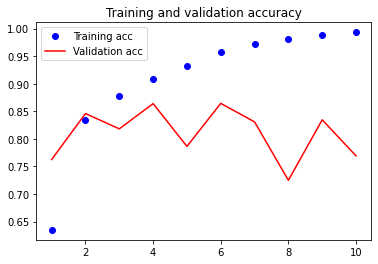

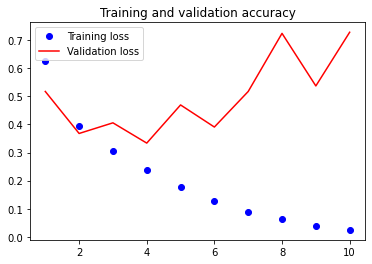

In [8]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

The accuracy in validation is higher than the obtained in the naive approach, but isn't much good. Part of the problem is that the inputs only consider the first 500 words, rather than the full sequences, hence, RNN has access to less information than earlier baseline model. The remainder of the problem is that SimpleRNN layer isn't good at processing long sequences, such as text.

## Long Short-Term Memory

A LSTM model can process lon sequences, that make LSTM a good approach for NLP task.

In [3]:
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Embedding(10000, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 8s 30ms/step - loss: 0.6011 - acc: 0.6849 - val_loss: 0.3888 - val_acc: 0.8390
Epoch 2/10
157/157 [==============================] - 4s 25ms/step - loss: 0.3074 - acc: 0.8832 - val_loss: 0.4246 - val_acc: 0.8046
Epoch 3/10
157/157 [==============================] - 4s 25ms/step - loss: 0.2312 - acc: 0.9121 - val_loss: 0.2852 - val_acc: 0.8820
Epoch 4/10
157/157 [==============================] - 4s 26ms/step - loss: 0.1919 - acc: 0.9290 - val_loss: 0.2909 - val_acc: 0.8876
Epoch 5/10
157/157 [==============================] - 4s 26ms/step - loss: 0.1540 - acc: 0.9462 - val_loss: 0.2920 - val_acc: 0.8850
Epoch 6/10
157/157 [==============================] - 4s 26ms/step - loss: 0.1503 - acc: 0.9465 - val_loss: 0.5083 - val_acc: 0.8552:
Epoch 7/10
157/157 [==============================] - 4s 27ms/step - loss: 0.1459 - acc: 0.9508 - val_loss: 0.4351 - val_acc: 0.8616 - loss: 0.1466 - ac
Epoch 8/10
157/157 [============================

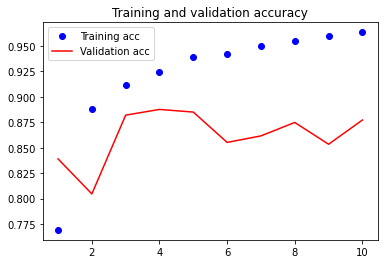

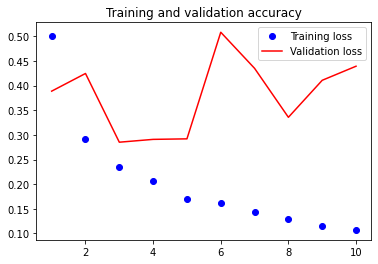

In [4]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

This time the accuracy is about 0.87 in validation. That is much better than SimpleRNN network, and the train is much fastter. The improve is because LSTM suffers much less from the vanishing-gradient problem, and slightly better than the fully connected approach.